In [1]:
import Data_generator_multiple as dg
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import math, random
import matplotlib.pyplot as plt
import UtilityLoss
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# initialize seed, mu, sigma, S0, paths, steps, T
torch.cuda.empty_cache()
seed = 36
num_stocks = 2
npaths = 80000
seq_length = 240
T=10
s0=np.array([3,8])
mu = np.array([0.0362, 0.01])
cov = np.array([[0.0225, 0.00132],[0.00132, 0.0016]])
trade_cost = 0.05
utility_gamma = 3.0001
is_one_liquid = True

# Notice the single is used only for plotting a 2 asset situation
if (num_stocks==2):
    rho = np.round(cov[0,1]/(np.sqrt(cov[0,0]*cov[1,1])),3)

In [3]:
# To determine optimal trading frequency, based on Johannes Muhle-Karbe's paper, higher dimension waited to be verified
# step 1: Calculting the Markowitz optimal
Markowitz_opt = np.matmul(np.linalg.inv(cov),mu)/utility_gamma
Markowitz_opt_tensor =  torch.tensor(Markowitz_opt,dtype = torch.float).to(device)
# step 2: Get the sigma where cov=sigma*sigma.transpose()
sigma = np.linalg.cholesky(cov)
# step 3: Calculate beta and the norm of beta through step 2
beta = -(sigma-np.matmul(Markowitz_opt,sigma))*np.transpose(Markowitz_opt)
beta_n = np.linalg.norm(beta)
# step 4: Calculate the optimal trading frequency
trade_f = math.pow(trade_cost*np.sqrt(2/np.pi)*beta_n/(utility_gamma/2*np.trace(np.matmul(np.matmul(beta.transpose(),sigma),beta))),2/3)
#seq_length = int(T/trade_f)
seq_length

240

In [4]:

# Define the distance for initial non trade region
delta = 0.01*np.power(np.diag(cov)*trade_cost,1/3)
#delta[0] = delta[0]*0.1
delta_tensor = torch.tensor(delta, dtype = torch.float)
print(Markowitz_opt+delta)
print(Markowitz_opt-delta)

[0.43616013 1.72472071]
[0.43408004 1.72385893]


In [5]:
# Create a stock simulation with prices, returns
stock = dg.ManyStocks(seed,num_stocks,mu,s0,cov,npaths,seq_length-1,T)
returns = torch.tensor(stock.Returns(),dtype=torch.float).to(device)
# Create a default strategy as initial input, better use the optimal strategy without cost
#strategy = -1*torch.ones((num_stocks,seq_length,npaths),dtype=torch.float).to(device)
strategy = (torch.tensor(Markowitz_opt,dtype=torch.float).view(num_stocks,1,1)*torch.ones((num_stocks,seq_length,npaths),dtype=torch.float)).to(device)
# Create a trading cost
cost =  torch.tensor(trade_cost*np.ones([num_stocks,seq_length-1,npaths]),dtype=torch.double).to(device)
cost[0,:,:]=0.00


In [6]:
# To determine the theoretical no trade region of 2 assets, one of which is liquid, to compare with RNN results
# the first asset is liquid and the second illiquid
if ((num_stocks==2) & (is_one_liquid==True)):
    rho = np.round(cov[0,1]/(np.sqrt(cov[0,0]*cov[1,1])),3)
    beta1 = np.sqrt(np.prod(np.diag(cov)))*rho/np.diag(cov)[1]
    beta2 = np.sqrt(np.prod(np.diag(cov)))*rho/np.diag(cov)[0]
    sigma_I = np.sqrt(np.diag(cov)[1]*(1-rho*rho))
    # Same as the Markowitz_optimal
    pi1 = (mu[0]-beta1*mu[1])/(utility_gamma*(1-rho*rho)*np.diag(cov)[0])
    pi2 = (mu[1]-beta2*mu[0])/(utility_gamma*(1-rho*rho)*np.diag(cov)[1])
    # lambda used to define the width of no trade region
    lamb = np.power(0.75*np.power(utility_gamma,2)*np.power(sigma_I,4)*pi2*pi2*(\
            np.power(beta2-mu[0]/(utility_gamma*np.diag(cov)[0]),2)*np.diag(cov)[0]\
            + np.power(1-pi2,2)*np.power(sigma_I,2)),1/3)*np.power(trade_cost,1/3)
    pi1_p = pi1+beta2*lamb/(utility_gamma*np.power(sigma_I,2))
    pi1_n = pi1-beta2*lamb/(utility_gamma*np.power(sigma_I,2))

In [7]:
# Calculate return of specific strategy
def cal_return(strat):   
    r0 = torch.sum(strat[:,:-1, :]*returns,0)
    r1 = r0-torch.sum(cost*abs((r0+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r2 = r0-torch.sum(cost*abs((r1+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r3 = r0-torch.sum(cost*abs((r2+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r4 = r0-torch.sum(cost*abs((r3+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r5 = r0-torch.sum(cost*abs((r4+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    return r5

class Cal_return(nn.Module):
    def __init__(self):
        
        super().__init__()

    def forward(self, strat):

        return cal_return(strat) 

In [8]:
# Define a log utility function
class LogUtilityLoss(torch.nn.Module):
    
    def __init__(self):
        super(LogUtilityLoss,self).__init__()
        
    def forward(self,x):
        loss = -torch.mean(torch.log(x))
        return loss

# Define a power utility function
class PowerUtilityLoss(torch.nn.Module):
    
    def __init__(self,gamma):
        super(PowerUtilityLoss,self).__init__()
        self.gamma = gamma
        
    def forward(self,x):
        loss = -torch.mean((torch.pow(x,1-self.gamma)-1)/(1-self.gamma))
        return loss

In [9]:
# Customize a RNN layer with double relu for multiple assets
# considering returns data to build a changed strategy weight according to price change
class MyRNN(nn.Module):

    def __init__(self, input_size, hidden_size, batch_size,dim_size):
        """Initialize params."""
        super(MyRNN, self).__init__()
        # read input parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.dim_size = dim_size

        self.input_param = nn.Linear(input_size, dim_size,  hidden_size).to(device)
        self.hidden_param = nn.Linear(hidden_size,  dim_size, hidden_size).to(device)
        self.fc1_param = nn.Linear(hidden_size, dim_size,hidden_size).to(device)
        self.fc2_param = nn.Linear(hidden_size, dim_size, hidden_size).to(device)
        # Define a rotate layer
        #self.rotate_param1 = nn.Linear(1,1,bias=False)
        #self.rotate_param2 = nn.Linear(1,1,bias=False)
        self.rotate_param = nn.Linear(dim_size,dim_size,bias=False)
        
    # Forward function allows a form:
    # h_t = w_fc2*relu(w_fc1*relu(w_inp*x_t+b_inp+w_h*h_{t-1}+b_h)+b_fc1)+b_fc2+b_fc1-b_h1
    def forward(self, input, hidden):
        
        def recurrence(input, hidden):
            # w_inp*x_t+b_inp+w_h*h_{t-1}+b_h
            ingate = self.input_param.weight.view(self.dim_size,self.input_size,self.hidden_size)*input \
                    + self.hidden_param.weight.view(self.dim_size,self.hidden_size,self.hidden_size)*hidden \
                    - Markowitz_opt_tensor.view(self.dim_size,self.input_size,self.hidden_size) \
                    + self.hidden_param.bias.view(self.dim_size,self.hidden_size,self.hidden_size)
            # w_fc1*relu(ingate)+b_fc1
            ingate2 = self.fc1_param.weight.view(self.dim_size,self.hidden_size,self.hidden_size)*F.relu(ingate)\
                    + 2*self.hidden_param.bias.view(self.dim_size,self.hidden_size,self.hidden_size)
            # w_fc2*relu(ingate2)+b_fc2+b_fc1-b_h1
            h       = self.fc2_param.weight.view(self.dim_size,self.hidden_size,self.hidden_size)*F.relu(ingate2)\
                    + Markowitz_opt_tensor.view(self.dim_size,self.input_size,self.hidden_size) \
                    + self.hidden_param.bias.view(self.dim_size,self.hidden_size,self.hidden_size)
            return h
        # Define the rotate function
        # def myrotate(input):
        #     input_new = input.squeeze(1)
        #     out = self.rotate_param.weight@input_new
        #     return out.unsqueeze(1)

        def myrotate(input_rotate):
            input_new = input_rotate.squeeze(1)
            out = torch.matmul(self.rotate_param.weight,input_new)
            #out1 = self.rotate_param1.weight*input_new[1,:]+input_new[0,:]
            #out2 = -self.rotate_param1.weight*input_new[0,:]+input_new[1,:]
            #out = torch.stack((out1,out2),0)
            return out.unsqueeze(1)

        output = []
        steps = range(input.size(1))
        myret = returns
        for i in steps:
            if i ==0:
                hidden = input[:,0,:].view(self.dim_size,1,self.batch_size).to(device)
                #hidden = (torch.tensor(Markowitz_opt,dtype=torch.float).view(self.dim_size,1,1)*torch.ones((self.dim_size,1,self.batch_size),dtype=torch.float)).to(device)
            else:
                # pi_t = myrotate(pi_{t-1}*(1+r_t)/(1+sum(pi_{t-1}*r_t))) due to change of price after rebalance
                adjust_pi = myrotate(\
                                    hidden.view(self.dim_size,1,self.batch_size)*(1+myret[:,i-1,:].view(self.dim_size,1,self.batch_size))\
                                    /(1+torch.sum(hidden.view(self.dim_size,1,self.batch_size)*myret[:,i-1,:].view(self.dim_size,1,\
                                    self.batch_size),0))\
                                    )

                hidden = myrotate(recurrence(input[:,i,:].view(self.dim_size,self.input_size,self.batch_size), adjust_pi))
                
            output.append(hidden)

        output = torch.cat(output, 1)

        return output, hidden

In [10]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, batch_size, seq_length, dim_size):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.dim_size = dim_size
        # the rnn layer which works as out, hidden_t = f(out_(t), hidden_(t-1)), used to approximate pi^*_(t)= f(pi^*_(t-1),pi_t)
        self.rnn = MyRNN(input_size, hidden_size, batch_size, dim_size).to(device)
        self.out = nn.Linear(dim_size, hidden_size,bias=False).to(device)
        # initialize some bias and weight
        self.rnn.input_param.weight = torch.nn.Parameter(torch.zeros_like(self.rnn.input_param.weight))
        self.rnn.hidden_param.weight = torch.nn.Parameter(torch.ones_like(self.rnn.hidden_param.weight))
        self.rnn.hidden_param.bias = torch.nn.Parameter(delta_tensor)
        self.rnn.fc1_param.bias = torch.nn.Parameter(2*delta_tensor)
        #self.rnn.hidden_param.bias = torch.nn.Parameter(-0.0*torch.ones_like(self.rnn.hidden_param.bias))
        #self.rnn.fc1_param.bias = torch.nn.Parameter(0.1*torch.ones_like(self.rnn.fc1_param.bias))
        self.rnn.fc1_param.weight = torch.nn.Parameter(-1*torch.ones_like(self.rnn.fc1_param.weight))
        self.rnn.fc2_param.weight = torch.nn.Parameter(-1*torch.ones_like(self.rnn.fc2_param.weight))
        #self.rnn.rotate_param1.weight = torch.nn.Parameter(torch.zeros(1))
        #self.rnn.rotate_param2.weight = torch.nn.Parameter(torch.zeros(1))
        self.rnn.rotate_param.weight = torch.nn.Parameter(torch.diag(torch.ones(self.dim_size)))
        #self.rnn.rotate_param.weight = torch.nn.Parameter(10*torch.rand((2,2)))
        self.out.weight = torch.nn.Parameter(*torch.ones_like(self.out.weight))

    def step(self, input, hidden=None):
        output, hidden = self.rnn(input, hidden).to(device)
        output2 = self.out.weight.view(dim_size,hidden_size,hidden_size)*output
        return output, output2

    def forward(self, inputs, hidden=None):
        hidden = self.__init__hidden().to(device)
        output, hidden = self.rnn(inputs.float(), hidden.float())
        # output2 the overall wealth at time T
        output2 = torch.prod(cal_return(output).to(device)+1,0)
        return  output, output2
        #return  output

    def __init__hidden(self):
        hidden = 0.0*torch.ones(self.dim_size, self.hidden_size,  self.batch_size,dtype=torch.float64).to(device)
        return hidden

In [11]:
# Set up model parameters, using paths as bath size, might not be the best, will try to fix later
n_epochs = 300
input_size = 1
hidden_size = 1
n_layers = 1
batch_size = npaths
seq_length = seq_length
dim_size = num_stocks

model = SimpleRNN(input_size, hidden_size, n_layers, batch_size, seq_length,dim_size).to(device)
#criterion = LogUtilityLoss()
criterion = PowerUtilityLoss(utility_gamma)
#model.rnn.bias_ih_l0.requires_grad = False
#model.rnn.bias_ih_l1.requires_grad = False
#model.rnn.weight_hh_l0.requires_grad = False
model.out.weight.requires_grad = False
model.rnn.input_param.weight.requires_grad = False
model.rnn.hidden_param.weight.requires_grad = False
model.rnn.fc1_param.weight.requires_grad = False
model.rnn.fc2_param.weight.requires_grad = False
model.rnn.fc1_param.bias.requires_grad = False
model.rnn.fc2_param.bias.requires_grad = False
#model.rnn.fc2_param.bias.requires_grad = True
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
#model.rnn.rotate_param.weight

In [12]:
# Loss for plotting
losses = np.zeros(n_epochs+1) 

for epoch in range(n_epochs+1):
    inputs = strategy.to(device)
    fina_strat, outputs = model(inputs.double(), None)

    loss = criterion(outputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses[epoch] += loss
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.0953, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
10 tensor(-0.0089, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
20 tensor(-0.0515, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
30 tensor(-0.0718, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
40 tensor(-0.0834, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
50 tensor(-0.0895, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
60 tensor(-0.0832, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
70 tensor(-0.0976, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
80 tensor(-0.0998, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
90 tensor(-0.0907, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
100 tensor(-0.1024, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
110 tensor(-0.1033, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
120 tensor(-0.0959, device='cuda:0', dty

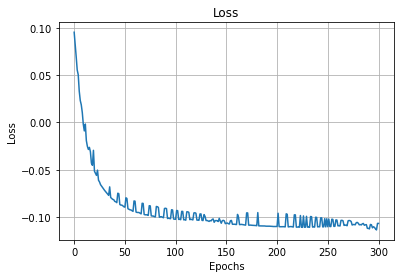

In [13]:
# Plot loss curve
epochs = range(n_epochs+1)

fig, ax = plt.subplots()
ax.plot(epochs, losses)

ax.set(xlabel='Epochs', ylabel='Loss',
       title='Loss')
ax.grid()
fig.savefig("loss_correl{}_mu{}_sigma{}.png".format(rho,mu,np.diag(cov)))

plt.show()

In [14]:
# output the weights and bias of the model parameter
for name, param in model.named_parameters():
     print (name, param.data)

rnn.input_param.weight tensor([[0.],
        [0.]], device='cuda:0')
rnn.input_param.bias tensor([0.9883, 0.6528], device='cuda:0')
rnn.hidden_param.weight tensor([[1.],
        [1.]], device='cuda:0')
rnn.hidden_param.bias tensor([0.0578, 0.0715], device='cuda:0')
rnn.fc1_param.weight tensor([[-1.],
        [-1.]], device='cuda:0')
rnn.fc1_param.bias tensor([0.0021, 0.0009], device='cuda:0')
rnn.fc2_param.weight tensor([[-1.],
        [-1.]], device='cuda:0')
rnn.fc2_param.bias tensor([-0.2913, -0.0479], device='cuda:0')
rnn.rotate_param.weight tensor([[ 0.9449, -0.0544],
        [ 0.0047,  0.9992]], device='cuda:0')
out.weight tensor([1., 1.], device='cuda:0')


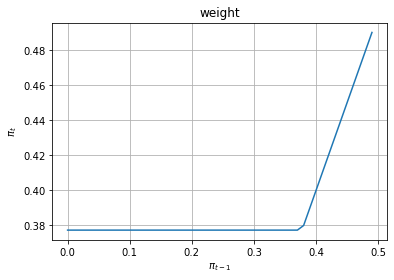

In [15]:
# Plot the non trade region of the first asset
t = torch.tensor(np.arange(-0, 0.5, 0.01)).to(device)
s = model.rnn.fc2_param.weight[0]*F.relu(model.rnn.fc1_param.weight[0]*F.relu(0.8*model.rnn.input_param.weight[0]-Markowitz_opt_tensor[0]+model.rnn.hidden_param.weight[0]*t+model.rnn.hidden_param.bias[0])+2*model.rnn.hidden_param.bias[0])+Markowitz_opt_tensor[0]+model.rnn.hidden_param.bias[0]

fig, ax = plt.subplots()
ax.plot(t.cpu().detach(), s.cpu().view(-1).detach())

ax.set(xlabel='$\pi_{t-1}$', ylabel='$\pi_t$',
       title='weight')
ax.grid()

fig.savefig("relu1.png")
plt.show()

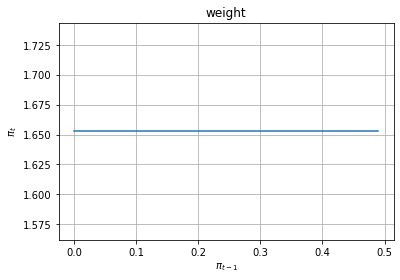

In [16]:
# Plot the non trade region of the second asset
t = torch.tensor(np.arange(0, 0.5, 0.01)).to(device)
s = model.rnn.fc2_param.weight[1]*F.relu(model.rnn.fc1_param.weight[0]*F.relu(0.8*model.rnn.input_param.weight[1]-Markowitz_opt_tensor[1]+model.rnn.hidden_param.weight[1]*t+model.rnn.hidden_param.bias[1])+2*model.rnn.hidden_param.bias[1])+Markowitz_opt_tensor[1]+model.rnn.hidden_param.bias[1]

fig, ax = plt.subplots()
ax.plot(t.cpu().detach(), s.cpu().view(-1).detach())

ax.set(xlabel='$\pi_{t-1}$', ylabel='$\pi_t$',
       title='weight')
ax.grid()

fig.savefig("relu2.png")
plt.show()

In [17]:
# figure out the a and b of each relu boundary
a1=Markowitz_opt[0]-model.rnn.hidden_param.bias[0].cpu().detach().numpy()
b1=Markowitz_opt[0]+model.rnn.hidden_param.bias[0].cpu().detach().numpy()
a2=Markowitz_opt[1]-model.rnn.hidden_param.bias[1].cpu().detach().numpy()
b2=Markowitz_opt[1]+model.rnn.hidden_param.bias[1].cpu().detach().numpy()

# Define the boundary matrix to plot
x = np.array([a1,b1,a1,b1])
y = np.array([a2,a2,b2,b2])
#c = np.array([[1,model.rnn.rotate_param1.weight.cpu().detach().numpy()[0]],[model.rnn.rotate_param1.weight.cpu().detach().numpy()[0],1]])
c = model.rnn.rotate_param.weight.cpu().detach().numpy()
xy = np.array([x,y])
xy2 = np.dot(c,xy)
xy3 = np.delete(xy2,1,1)
xy4 = np.delete(xy2,2,1)

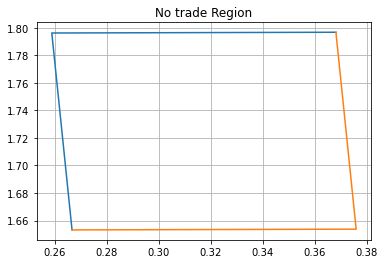

In [18]:
# Plot the actual boundary of adjusted non-trade region of certain covriance matrix
fig, ax = plt.subplots()
ax.plot(xy3[0,:], xy3[1,:])
ax.plot(xy4[0,:], xy4[1,:])
ax.grid()
ax.set(title='No trade Region')
fig.savefig("correl{}_mu{}_sigmasquare{}.png".format(rho,mu,np.diag(cov)))
plt.show()

In [19]:
print(criterion(torch.prod(cal_return(strategy)+1,0)))
print(criterion(torch.prod(cal_return(fina_strat)+1,0)))
print(torch.prod(cal_return(strategy)+1,0))

tensor(0.1022, device='cuda:0', dtype=torch.float64)
tensor(-0.1067, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.7993, 0.8611, 0.6315,  ..., 0.6842, 0.6486, 1.2987], device='cuda:0',
       dtype=torch.float64)
